In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import wordcloud
import Uncertainty as unc
import UncertaintyM as uncM
import matplotlib.pyplot as plt
import data_provider as dp
from classes.wordclouds import Wordcloud
from wordcloud import STOPWORDS

In [7]:
episodes = 100
unc_embeddings = 10
test_split = 0.3
log = True
unc_plot = False
seed = 1

In [3]:
# load the data
features_all, targets_all, text_all = dp.load_data("./Data/")
features_list, targets_list, text_list = dp.partition_data(features_all, targets_all, text_all, episodes)

episode  0
------------------------------------
model test score =  0.6249201550057488
Counter({'movie': 30, 'quot': 18, 'one': 14, 'film': 14, 'action': 13, 'great': 11, 'time': 9, 'will': 8, 'best': 8, 'watch': 8, 'john': 7, 'patton': 7, 'films': 6, 'know': 6, 'excellent': 6, 'video': 6, 'really': 5, 'even': 5, 'life': 5, 'dialogue': 5, 'scenes': 5, 'little': 5, 'see': 5, 'almost': 5, 'acting': 5, 'story': 5, 'screen': 5, 'good': 4, 'scene': 4, 'true': 4, 'isn': 4, 'long': 4, 'although': 4, 'don': 4, 'sure': 4, 'anyone': 4, 'face': 4, 'many': 4, 'pink': 4, 'stars': 4, 'someone': 4, 'shakespeare': 4, 'kat': 4, 'bianca': 4, 'savannah': 4, 'reese': 4, 'hilarious': 3, 'better': 3, 'done': 3, 'plot': 3, 'actually': 3, 'makes': 3, 'though': 3, 'classic': 3, 'far': 3, 'favorite': 3, 'movies': 3, 'doesn': 3, 'made': 3, 'boys': 3, 'music': 3, 'horror': 3, 'old': 3, 'hear': 3, 'may': 3, 'around': 3, 'superb': 3, 'well': 3, 'rather': 3, 'direction': 3, 'find': 3, 'two': 3, 'greatest': 3, 'every

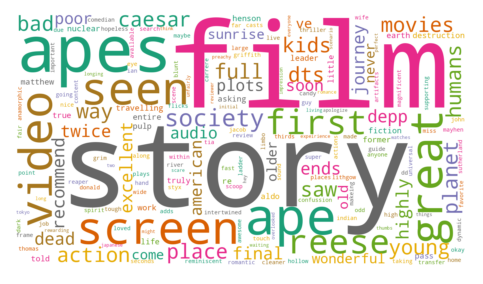

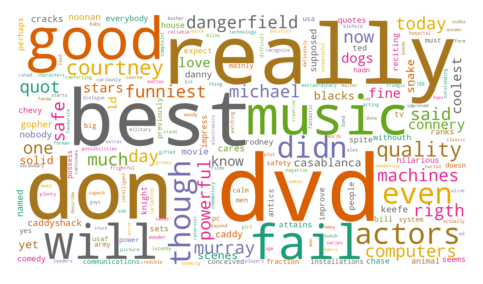

In [8]:
for episode, (features, targets, texts) in enumerate(zip(features_list, targets_list, text_list)):

    print("episode ", episode)
    print("------------------------------------")

    # split and shuffel the data
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_split, shuffle=False, random_state=seed)
    _,       text_test, _   , _      = train_test_split(texts,    targets, test_size=test_split, shuffle=False, random_state=seed)

    # train the model
    model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
    model.fit(X_train, y_train[:,0]) # remove keys when fiting the model

    predictions = model.predict(X_test)
    if log:
        print("model test score = ", model.score(X_test, y_test[:,0]))

    # Aleatoric uncertianty for X_test
    total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train[:,0])

    # AR plot
    if unc_plot:
        avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test[:,0].reshape((1,-1)), total_uncertainty.reshape((1,-1)))
        plt.plot(steps, avg_acc*100)
        plt.savefig(f"./Results/AR_plot.png",bbox_inches='tight')

    # sort based on uncertianty
    sorted_index = np.argsort(-total_uncertainty, kind='stable')
    text_test = np.array(text_test)
    text_test = text_test[sorted_index]
    # epistemic_uncertainty = epistemic_uncertainty[sorted_index]

    # Get uncertainty per class
    u = np.unique(y_test[:,0]) # find the unique classes

    unc_sorted_class_list = []
    tokens_all = None
    for i in u: # this loop runs for every class in the dataset
        index = np.where(y_test[:,0]==i)[0]
        unc_sorted_class_text = text_test[index]

        wordcloud_text_array = unc_sorted_class_text[:unc_embeddings]
        tokens_high = wordcloud.get_tokens(list(wordcloud_text_array))

        wordcloud_text_array = unc_sorted_class_text[-unc_embeddings:]
        tokens_low = wordcloud.get_tokens(list(wordcloud_text_array))

        class_tokens = tokens_high + tokens_low
        print(class_tokens)
        print("------------------------------------")
        if tokens_all == None:
            tokens_all = class_tokens
        else:
            tokens_all += class_tokens

        # unc_sorted_class_list.append(text_test[index])
    print("------------------------------------")
    print(tokens_all)
    exit()
    # Create wordcloud
    wordcloud = Wordcloud()

    wordcloud_text_array = text_test[:10]
    tokens_high = wordcloud.get_tokens(list(wordcloud_text_array))

    wordcloud_text_array = text_test[-10:]
    tokens_low = wordcloud.get_tokens(list(wordcloud_text_array))

    tokens_c = tokens_low - tokens_high
    cloud = wordcloud.get_wordcloud(tokens_c)
    wordcloud.plot(cloud, f"LowsubHigh_{episode}")

    tokens_c = tokens_high - tokens_low
    cloud = wordcloud.get_wordcloud(tokens_c)
    wordcloud.plot(cloud, f"HighsubLow_{episode}")

    break
    
